In [1]:
sc
import numpy as np

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
key_id='YOUR_KEY_ID'
access_key='YOUR_ACCESS_KEY'
region="us-east-2"
sc.setSystemProperty("com.amazonaws.services.s3.enableV4","true")
sc._jsc.hadoopConfiguration().set("fs.s3a.awsAccessKeyId",key_id)
sc._jsc.hadoopConfiguration().set("fs.s3a.awsSecretAccessKey",access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint","s3-"+region+".amazonaws.com")

In [3]:
complete_dataset_path = "PATH/TO/COMPLETE/DATASET"
small_dataset_path = "PATH/TO/SMALL/DATASET"

In [4]:
# Load the complete dataset file
complete_ratings_file = complete_dataset_path+'ratings.csv'
complete_ratings_raw_data = sc.textFile(complete_ratings_file)
complete_ratings_raw_data_header = complete_ratings_raw_data.take(1)[0]

# Parse
complete_ratings_data = complete_ratings_raw_data.filter(lambda line: line!=complete_ratings_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),int(tokens[1]),float(tokens[2]))).cache()
    
print ("There are %s recommendations in the complete dataset" % (complete_ratings_data.count()))

There are 26024289 recommendations in the complete dataset


In [5]:
#Selecting user id 1 as test user and selecting 10 movies rated by that user to predict the ratings for the rest of 17 movies
test_user_ID=1
new_user_ratings=complete_ratings_data.filter(lambda x: x[0]==test_user_ID)
new_user_ratings_RDD=sc.parallelize(new_user_ratings.take(10))
print(new_user_ratings_RDD.collect())
movies_selected_for_test_user=new_user_ratings_RDD.map(lambda x: x[1]).collect()
print(movies_selected_for_test_user)
movies_of_test_user=new_user_ratings.map(lambda x: x[1])
print(movies_of_test_user.collect())
movies_notselected_for_test_user_RDD=movies_of_test_user.filter(lambda x: x not in movies_selected_for_test_user)
movies_notselected_for_test_user=movies_notselected_for_test_user_RDD.collect()
movies_notselected_for_test_user

[(1, 110, 1.0), (1, 147, 4.5), (1, 858, 5.0), (1, 1221, 5.0), (1, 1246, 5.0), (1, 1968, 4.0), (1, 2762, 4.5), (1, 2918, 5.0), (1, 2959, 4.0), (1, 4226, 4.0)]
[110, 147, 858, 1221, 1246, 1968, 2762, 2918, 2959, 4226]
[110, 147, 858, 1221, 1246, 1968, 2762, 2918, 2959, 4226, 4878, 5577, 33794, 54503, 58559, 59315, 68358, 69844, 73017, 81834, 91500, 91542, 92439, 96821, 98809, 99114, 112552]


[4878,
 5577,
 33794,
 54503,
 58559,
 59315,
 68358,
 69844,
 73017,
 81834,
 91500,
 91542,
 92439,
 96821,
 98809,
 99114,
 112552]

In [6]:
#Calculating global average
global_average=(complete_ratings_data.map(lambda x: x[2]).reduce(lambda x, y: x+y)/(complete_ratings_data.count()*1.0))

In [8]:
#Calculating the average of each movie
def get_counts_and_averages(ID_and_ratings_tuple):
    nratings = len(ID_and_ratings_tuple[1])
    return ID_and_ratings_tuple[0], (nratings, float(sum(x for x in ID_and_ratings_tuple[1]))/nratings)

movie_ID_with_ratings_RDD = (complete_ratings_data.map(lambda x: (x[1], x[2])).groupByKey())
movie_ID_with_avg_ratings_RDD = movie_ID_with_ratings_RDD.map(get_counts_and_averages)
movie_rating_counts_RDD = movie_ID_with_avg_ratings_RDD.map(lambda x: (x[0], x[1][0]))
movie_average=movie_ID_with_avg_ratings_RDD.map(lambda x: (x[0], x[1][1]))
movie_average.take(10)

[(90112, 2.25),
 (135168, 3.1666666666666665),
 (65538, 3.35),
 (40964, 2.125),
 (88748, 3.0),
 (147466, 2.0),
 (123024, 2.375),
 (122892, 3.5949802303592917),
 (155650, 1.0),
 (8206, 3.1216216216216215)]

In [11]:
#Calculating the average of rating of 10 selected movies for test user
def get_counts_and_averages(ID_and_ratings_tuple):
    nratings = len(ID_and_ratings_tuple[1])
    return ID_and_ratings_tuple[0], (nratings, float(sum(x for x in ID_and_ratings_tuple[1]))/nratings)

user_ID_with_ratings_RDD = (new_user_ratings.map(lambda x: (x[0], x[2])).groupByKey())
user_ID_with_avg_ratings_RDD = user_ID_with_ratings_RDD.map(get_counts_and_averages)
user_rating_counts_RDD = user_ID_with_avg_ratings_RDD.map(lambda x: (x[0], x[1][0]))

user_ID_with_avg_ratings_RDD.sortByKey(True, 1).take(10)

user_average=user_ID_with_avg_ratings_RDD.map(lambda x: (x[1][1]))
u_avg=user_average.take(1)[0]
u_avg

4.277777777777778

In [18]:
#Predicting ratings for the rest 17 movies which where already rated by the test user
movieavgdict=movie_average.collectAsMap()

def predicter(unrated_movies_tuple):
    movierating=movieavgdict[unrated_movies_tuple]
    return unrated_movies_tuple, (global_average+(u_avg - global_average)+(movierating - global_average))
baseline_prediction_RDD = movies_notselected_for_test_user_RDD.map(predicter)

movies_id=baseline_prediction_RDD.map(lambda x:x[0]).collect()
prediction=baseline_prediction_RDD.map(lambda x:round(round(x[1],2)*2)/2).collect()

not_rated_movies = new_user_ratings.filter(lambda x: x[1] not in movies_selected_for_test_user)
original_rating=not_rated_movies.map(lambda x:x[2]).collect()

import numpy as np
import pandas as pd
pddf=pd.DataFrame({'Movie ID':movies_id,
                 'Predicted Rating':prediction,
                  'Original Rating':original_rating})
pddf

,Movie ID,Original Rating,Predicted Rating
0,4878,5.0,4.5
1,5577,5.0,4.5
2,33794,4.0,4.5
3,54503,3.5,4.5
4,58559,4.0,5.0
5,59315,5.0,4.5
6,68358,5.0,4.5
7,69844,5.0,4.5
8,73017,5.0,4.5
9,81834,5.0,4.5


In [19]:
baseline_prediction_rating = baseline_prediction_RDD.map(lambda x:(round(round(x[1],2)*2)/2)*2)
predicted_data=baseline_prediction_rating.collect()
org_predicted_data=baseline_prediction_rating.collect()

In [20]:
not_rated_movies_rating = not_rated_movies.map(lambda x:x[2]*2)
test_data=not_rated_movies_rating.collect()
org_test_data=not_rated_movies_rating.collect()

In [23]:
#Calculating if the the predicted data matched the original data
for ind in range(len(predicted_data)):
    predicted_data[ind] = 1 if org_test_data[ind]-0.5<=org_predicted_data[ind]<=org_test_data[ind]+0.5 else 0
    test_data[ind]=org_test_data[ind]/10
print (predicted_data)
print (test_data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[1.0, 1.0, 0.8, 0.7, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.1, 0.8, 1.0]


In [24]:
%matplotlib inline

In [25]:
#Calculating f1 score, precision score and recall score for the predicted values
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("f1_score=",f1_score(org_test_data, org_predicted_data, average="macro"))
print("precision_score=",precision_score(org_test_data, org_predicted_data, average="macro"))
print("recall_score=",recall_score(org_test_data, org_predicted_data, average="macro")) 

f1_score= 0.0238095238095
precision_score= 0.0555555555556
recall_score= 0.0151515151515


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [27]:
#Calculating average precision score for predicted ratings vs original ratings
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(predicted_data, test_data)

print('Average precision score: {0:0.2f}'.format(
      average_precision))

Average precision score: 0.55


[ 0.09090909  1.        ]
[ 1.  0.]


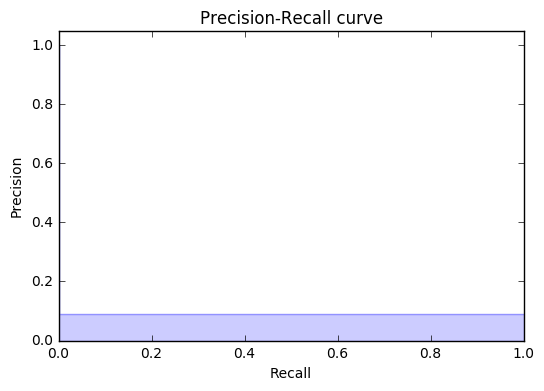

In [28]:
#Plottinf precision-recall curve for the predicted ratings vs original ratings
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(predicted_data, test_data)
print (precision)
print (recall)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')

In [29]:
#Calculating the RMSE of the predictions
import math
diff_sq_list=[]
for ind in range(len(org_predicted_data)):
    diff=org_predicted_data[ind]-org_test_data[ind]
    diff_sq=diff**2
    diff_sq_list.append(diff_sq)
rmse=math.sqrt(sum(diff_sq_list)/float(len(diff_sq_list)))
print ("Root mean squared error =",rmse)

Root mean squared error = 2.497057091387191
